## Kalashnik 1994


In [1]:
# General
import glob
import os.path
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

# Arrays & Displays
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
# from matplotlib.colors import Normalize
# from matplotlib.colors import ListedColormap
import matplotlib.cm as cm
import pandas as pd

# Data treatment
import dask as da
from dask.diagnostics import ProgressBar
import zarr
from scipy.interpolate import griddata
from scipy.signal import convolve2d
from scipy.signal import argrelextrema
from datetime import datetime

# Custom
import functions as f

# Default parameters
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

In [2]:
PARAMS = {'save_figs':       False,
#           'data_dir':        '/home/arthur/data/cyclobs/centered_rotated_files_31012022/',
          'ds_glob_path':    '/home/arthur/data/cyclobs/SAR_compilations_in_nc/SAR_centered_rotated_files_13052022_with_extra_params.nc',
#           'ds_glob_path_Rw': '/home/arthur/data/cyclobs/SAR_compilations_in_nc/ds_glob_Rw',
#           'save_dir':        '/home/arthur/results/ck22model/ck22model_scatter/lat30_cat1_allbasins/',
          
#           'filter_data':     True, # If True, filters out storms and TC > 30°N
}

### OPEN DATA
dsg = xr.open_dataset(PARAMS['ds_glob_path'])
# ds_glob = xr.open_dataset(PARAMS['ds_glob_path_Rw'])
print('Nb of storms: {}'.format(len(dsg.time)))

Nb of storms: 335


In [68]:
### FUNCTIONS
def coriolis(lat):
    '''Latitude must be in degrees.'''
    Omega = 7.2921e-5                            # Earth rotation vector
    fcor  = 2 * Omega * np.sin(lat * np.pi / 180) # Coriolis parameter at 20° latitude and assuming it's constant 
    return fcor

#### Equation 13

Rmax = R0 ^ 3 * f ^ 2 / (4 * V0 ^ 2)

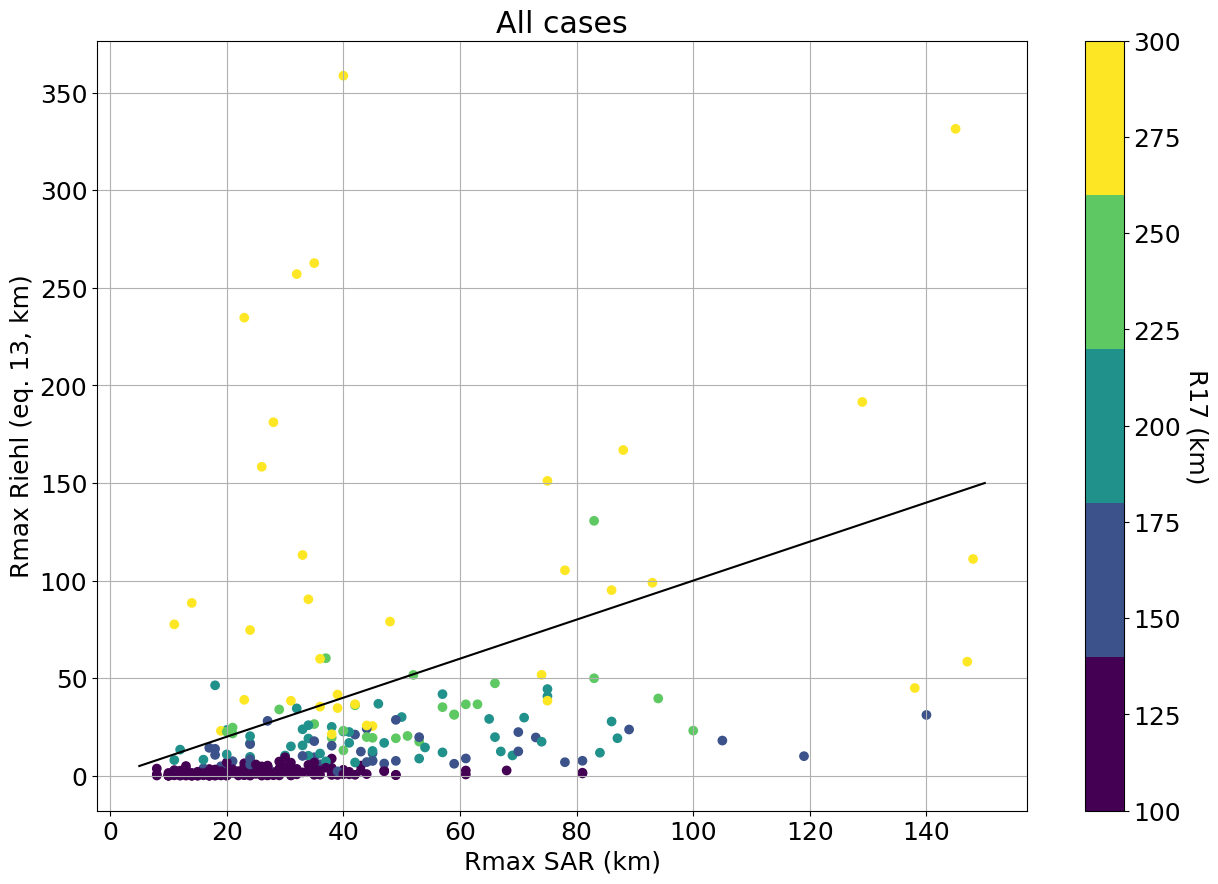

In [61]:
dsg['ri'] = ((dsg['R17_1D'] * 1000) ** 3) * (coriolis(abs(dsg['lat_center'])) ** 2) / (4 * 17.5 ** 2)

plt.title('All cases')
plt.scatter(dsg['Rmax_1D'], dsg['ri'] / 1000, c=dsg['R17_1D'], vmin=100, vmax=300, cmap=cm.get_cmap('viridis', 5))
plt.xlabel('Rmax SAR (km)');plt.ylabel('Rmax Riehl (eq. 13, km)')
plt.grid()

plt.plot([5, 150], [5, 150], c='k')

cbar    = plt.colorbar()
cbar.set_label('R17 (km)', rotation=270)
cbar.ax.get_yaxis().labelpad=20

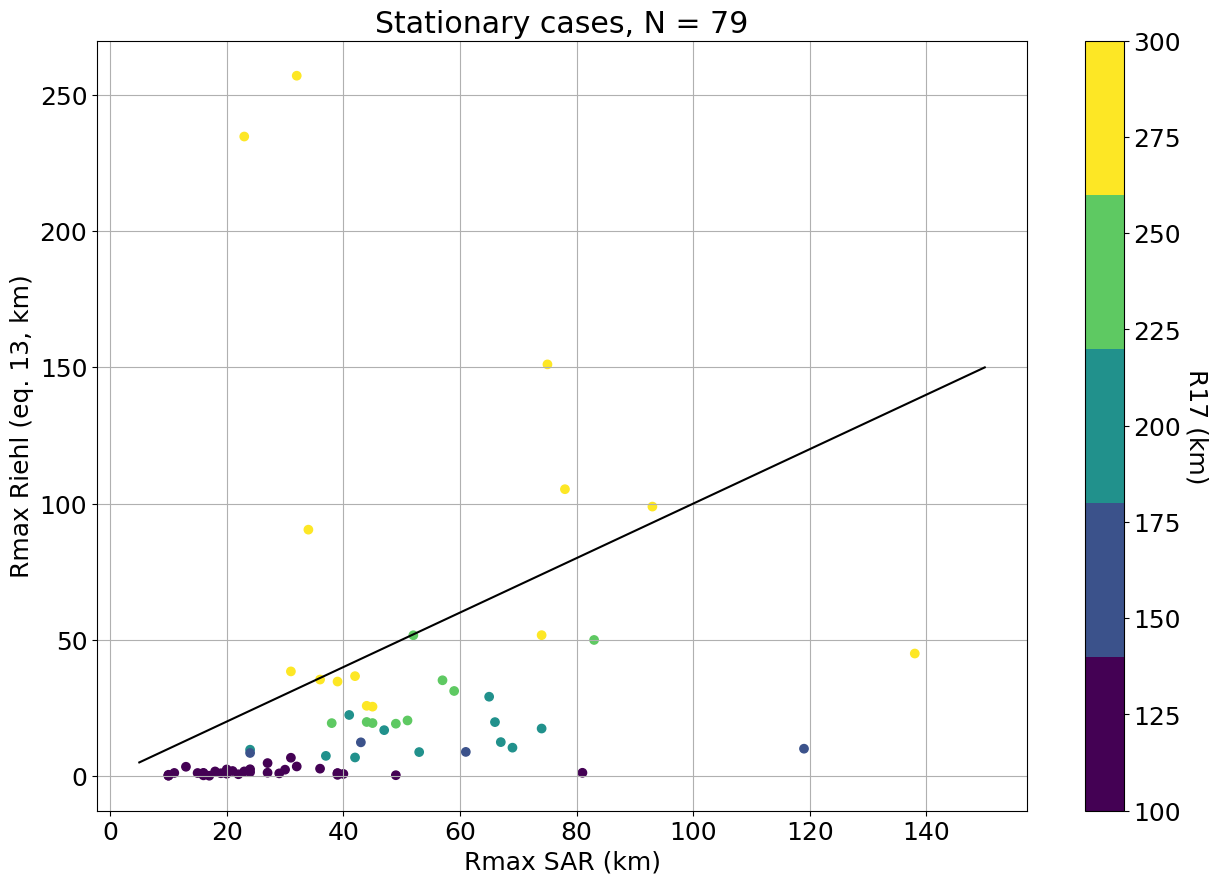

In [62]:
dsg2 = xr.open_dataset('/home/arthur/results/TCsLifeMonitFromObs/07_SAR_K10/ds_glob.nc')
dsg['Vmax_dot_smth_IBT'] = dsg2['Vmax_dot_smth_IBT']

d = dsg.where(abs(dsg.Vmax_dot_smth_IBT) < 0.3, drop=True)
d = d.where(abs(d.lat_center) < 30, drop=True)
d = d.where(d.distance_to_coast > 200000, drop=True)

plt.title('Stationary cases, N = {}'.format(len(d.time)))
plt.scatter(d['Rmax_1D'], d['ri'] / 1000, c=d['R17_1D'], vmin=100, vmax=300, cmap=cm.get_cmap('viridis', 5))
plt.xlabel('Rmax SAR (km)');plt.ylabel('Rmax Riehl (eq. 13, km)')
plt.grid()

plt.plot([5, 150], [5, 150], c='k')

cbar    = plt.colorbar()
cbar.set_label('R17 (km)', rotation=270)
cbar.ax.get_yaxis().labelpad=20

In [47]:
# plt.title('All cases')
# plt.scatter(dsg['Rmax_1D'], dsg['ri'] / 1000, c=dsg['Vmax_1D'], cmap=cm.get_cmap('viridis', 5), vmin=30, vmax=50);plt.colorbar()
# plt.xlabel('Rmax SAR (km)');plt.ylabel('Rmax Riehl (eq. 13, km)')
# plt.grid()

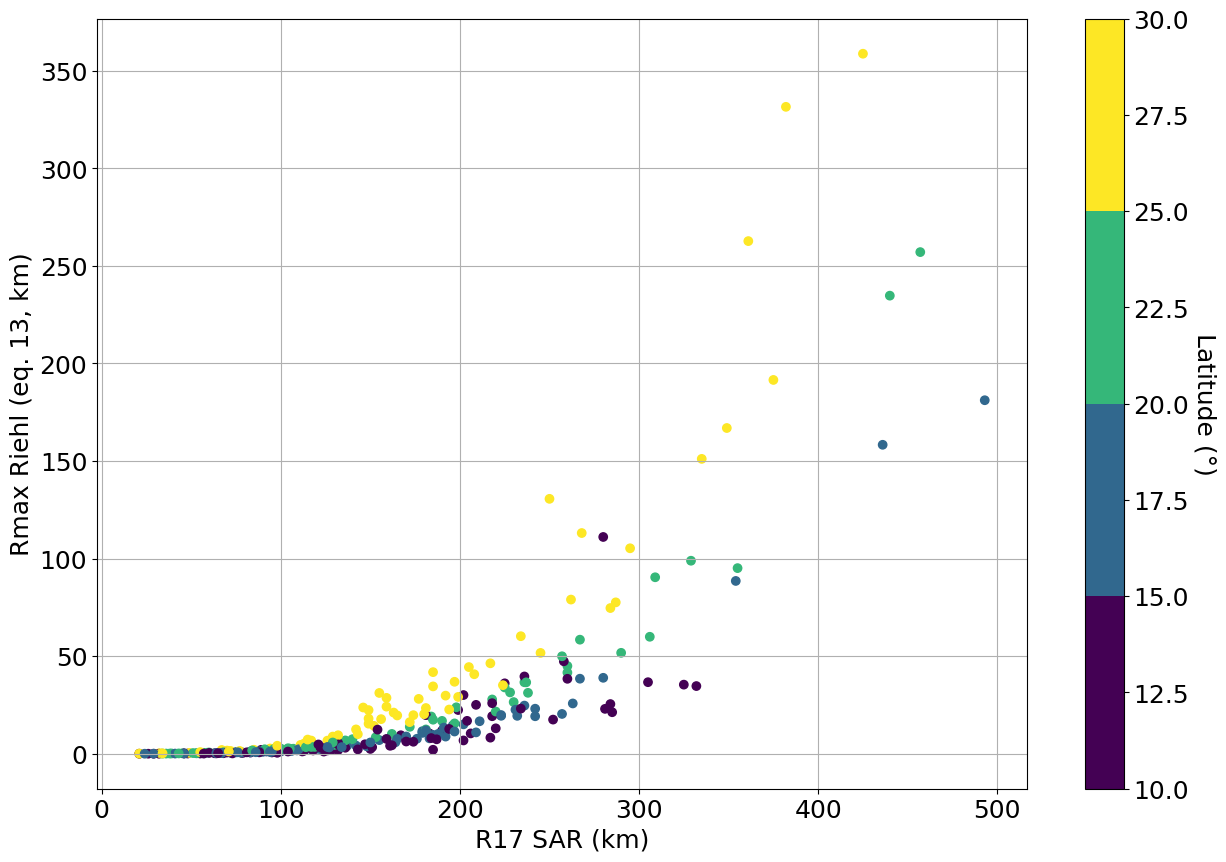

In [65]:
plt.scatter(dsg['R17_1D'], dsg['ri'] / 1000, c=dsg['lat_center'], cmap=cm.get_cmap('viridis', 4), vmin=10, vmax=30)
# plt.scatter(dsg['R17_1D'], dsg['Rmax_1D'], c=dsg['lat_center'], cmap=cm.get_cmap('viridis', 4), vmin=10, vmax=30)
plt.xlabel('R17 SAR (km)');plt.ylabel('Rmax Riehl (eq. 13, km)')
plt.grid()

cbar    = plt.colorbar()
cbar.set_label('Latitude (°)', rotation=270)
cbar.ax.get_yaxis().labelpad=20

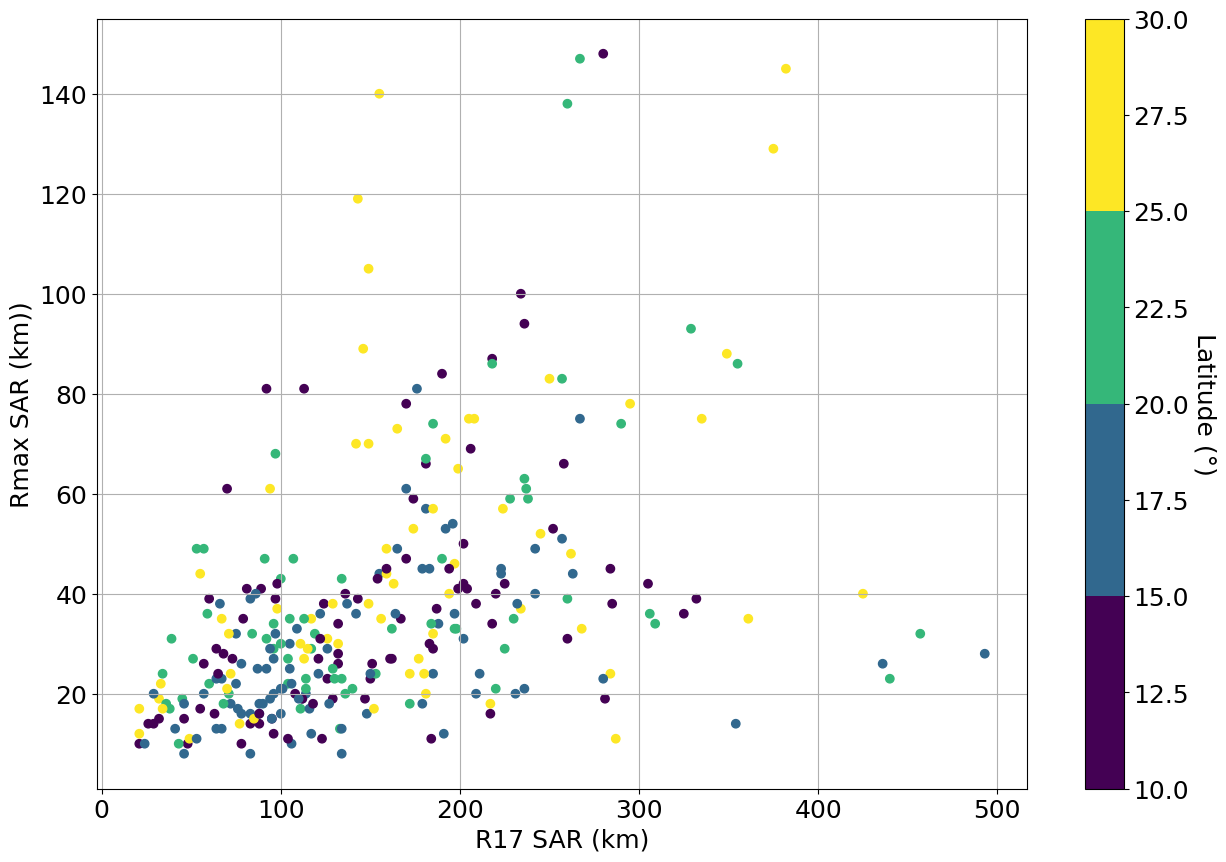

In [67]:
plt.scatter(dsg['R17_1D'], dsg['Rmax_1D'], c=dsg['lat_center'], cmap=cm.get_cmap('viridis', 4), vmin=10, vmax=30)
plt.xlabel('R17 SAR (km)');plt.ylabel('Rmax SAR (km))')
plt.grid()

cbar    = plt.colorbar()
cbar.set_label('Latitude (°)', rotation=270)
cbar.ax.get_yaxis().labelpad=20

#### Equation 14

Vmax = 2 * V17 ** 2 / (f * R17)

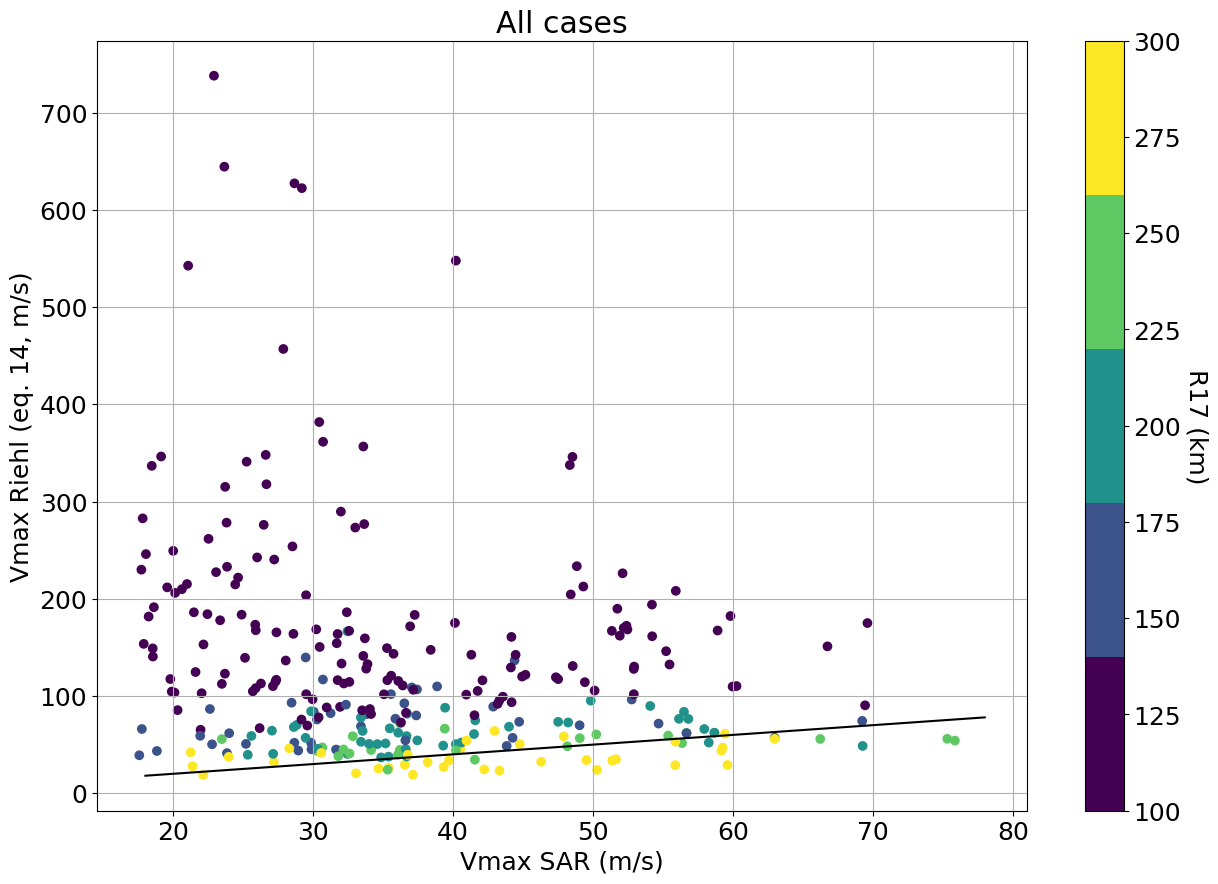

In [72]:
dsg['vi'] = 2 * 17.5 ** 2 / (coriolis(abs(dsg['lat_center'])) * dsg['R17_1D'] * 1000)

plt.title('All cases')
plt.scatter(dsg['Vmax_1D'], dsg['vi'], c=dsg['R17_1D'], vmin=100, vmax=300, cmap=cm.get_cmap('viridis', 5))
plt.xlabel('Vmax SAR (m/s)');plt.ylabel('Vmax Riehl (eq. 14, m/s)')
plt.grid()

plt.plot([18, 78], [18, 78], c='k')

cbar    = plt.colorbar()
cbar.set_label('R17 (km)', rotation=270)
cbar.ax.get_yaxis().labelpad=20

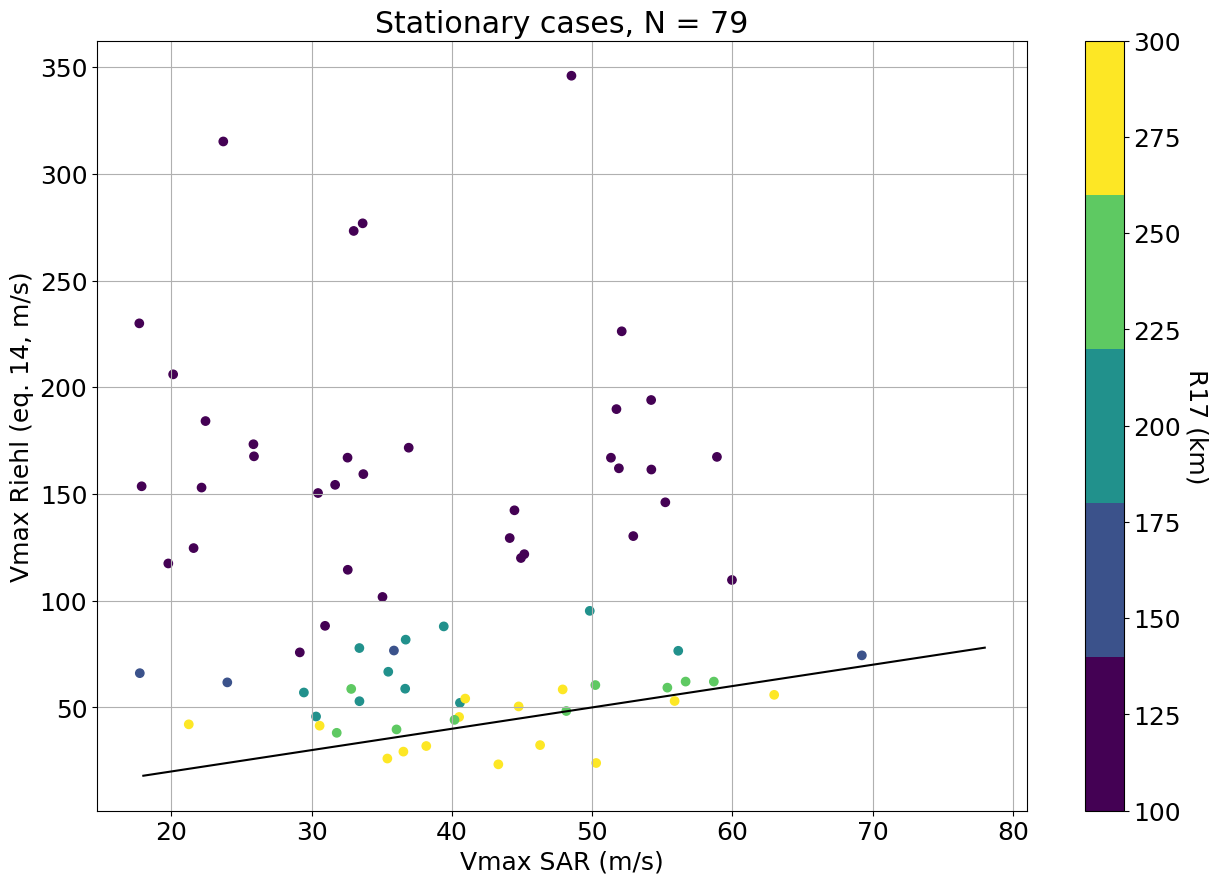

In [73]:
d = dsg.where(abs(dsg.Vmax_dot_smth_IBT) < 0.3, drop=True)
d = d.where(abs(d.lat_center) < 30, drop=True)
d = d.where(d.distance_to_coast > 200000, drop=True)

plt.title('Stationary cases, N = {}'.format(len(d.time)))
plt.scatter(d['Vmax_1D'], d['vi'], c=d['R17_1D'], vmin=100, vmax=300, cmap=cm.get_cmap('viridis', 5))
plt.xlabel('Vmax SAR (m/s)');plt.ylabel('Vmax Riehl (eq. 14, m/s)')
plt.grid()

plt.plot([18, 78], [18, 78], c='k')

cbar    = plt.colorbar()
cbar.set_label('R17 (km)', rotation=270)
cbar.ax.get_yaxis().labelpad=20

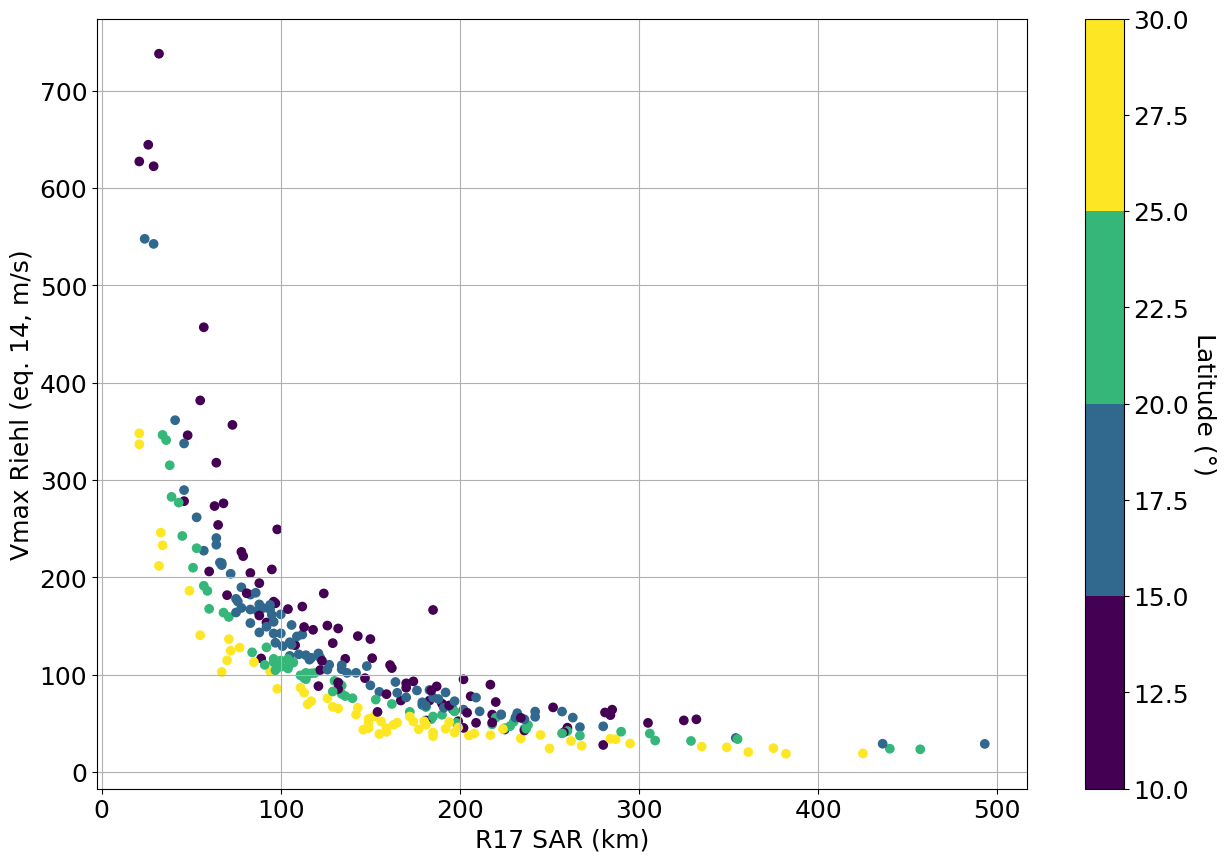

In [77]:
plt.scatter(dsg['R17_1D'], dsg['vi'], c=dsg['lat_center'], cmap=cm.get_cmap('viridis', 4), vmin=10, vmax=30)
plt.xlabel('R17 SAR (km)');plt.ylabel('Vmax Riehl (eq. 14, m/s)')
plt.grid()

cbar    = plt.colorbar()
cbar.set_label('Latitude (°)', rotation=270)
cbar.ax.get_yaxis().labelpad=20

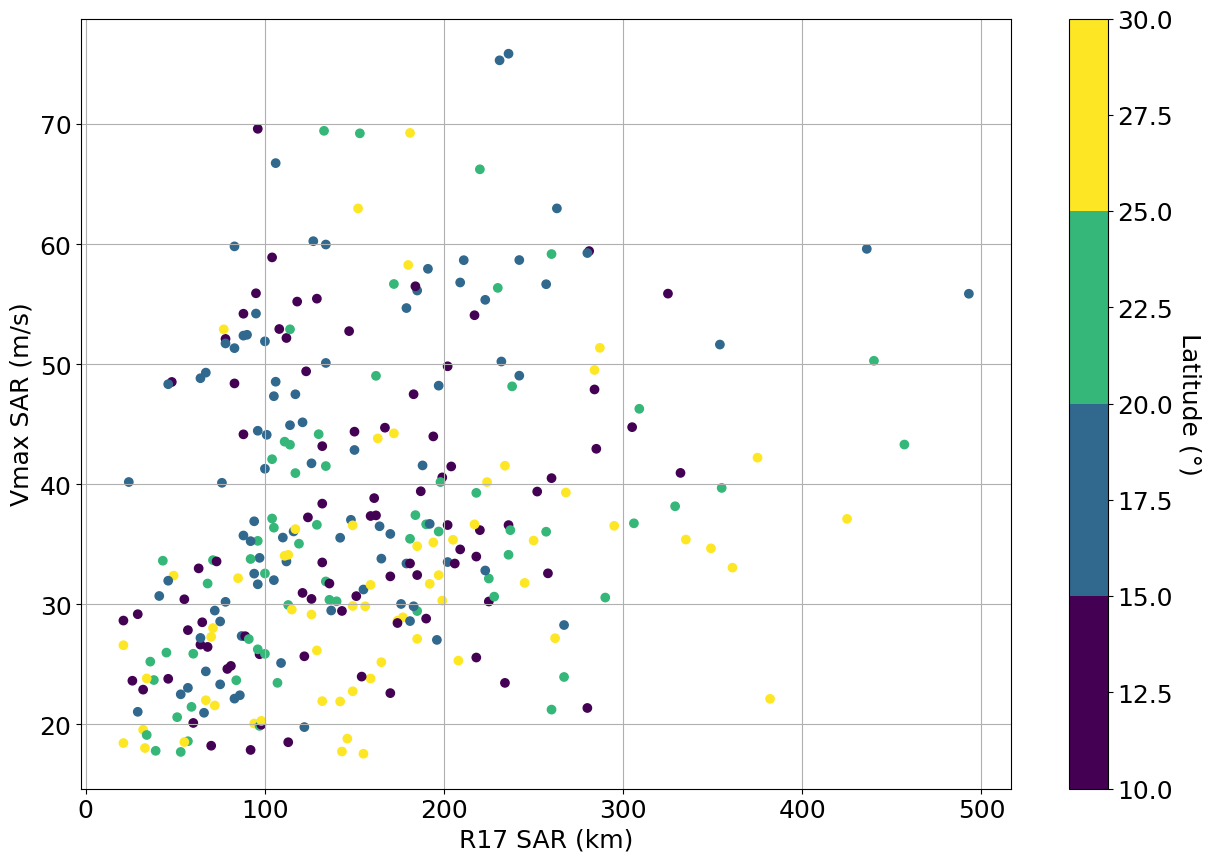

In [78]:
plt.scatter(dsg['R17_1D'], dsg['Vmax_1D'], c=dsg['lat_center'], cmap=cm.get_cmap('viridis', 4), vmin=10, vmax=30)
plt.xlabel('R17 SAR (km)');plt.ylabel('Vmax SAR (m/s)')
plt.grid()

cbar    = plt.colorbar()
cbar.set_label('Latitude (°)', rotation=270)
cbar.ax.get_yaxis().labelpad=20

In [107]:
# d = dsg.where(abs(dsg.B_hol - 2) < 0.1, drop=True)

# plt.title('All cases')
# plt.scatter(d['Vmax_1D'], d['vi'], c=d['R17_1D'], vmin=100, vmax=300, cmap=cm.get_cmap('viridis', 5))
# plt.xlabel('Vmax SAR (m/s)');plt.ylabel('Vmax Riehl (eq. 14, m/s)')
# plt.grid()

# plt.plot([18, 78], [18, 78], c='k')

# cbar    = plt.colorbar()
# cbar.set_label('R17 (km)', rotation=270)
# cbar.ax.get_yaxis().labelpad=20

#### Conservation of PV?

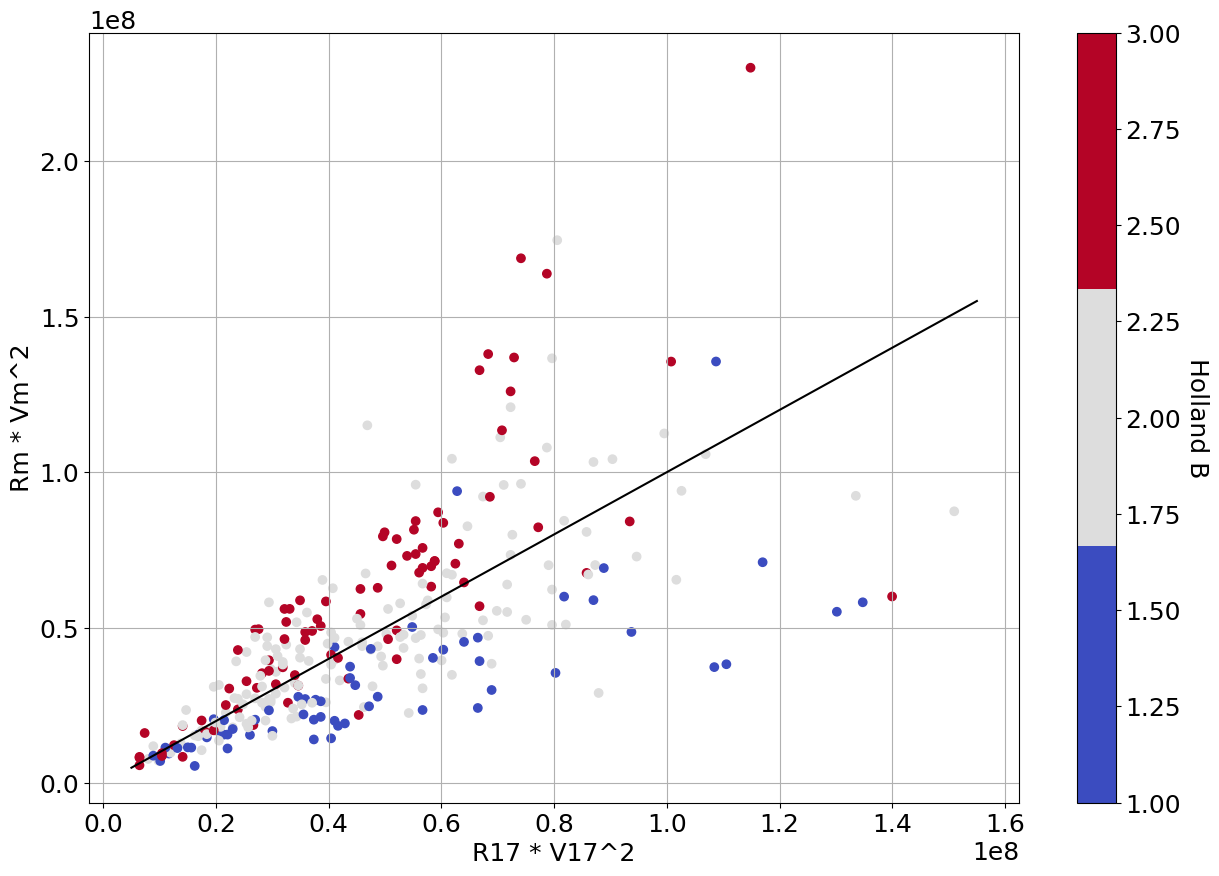

In [103]:
# plt.scatter(dsg['R17_1D'] * 1000 * 17.5 ** 2, dsg['Rmax_1D'] * 1000 * dsg['Vmax_1D'] ** 2, c=dsg.Vmax_dot_smth_IBT, vmin=-1, vmax=1, cmap=cm.get_cmap('coolwarm', 3))
plt.scatter(dsg['R17_1D'] * 1000 * 17.5 ** 2, dsg['Rmax_1D'] * 1000 * dsg['Vmax_1D'] ** 2, c=dsg.B_hol, vmin=1, vmax=3, cmap=cm.get_cmap('coolwarm', 3))
plt.grid()
plt.xlabel('R17 * V17^2');plt.ylabel('Rm * Vm^2')

cbar    = plt.colorbar()
cbar.set_label('Holland B', rotation=270)
cbar.ax.get_yaxis().labelpad=20

plt.plot([0.05e8, 1.55e8], [0.05e8, 1.55e8], c='k')

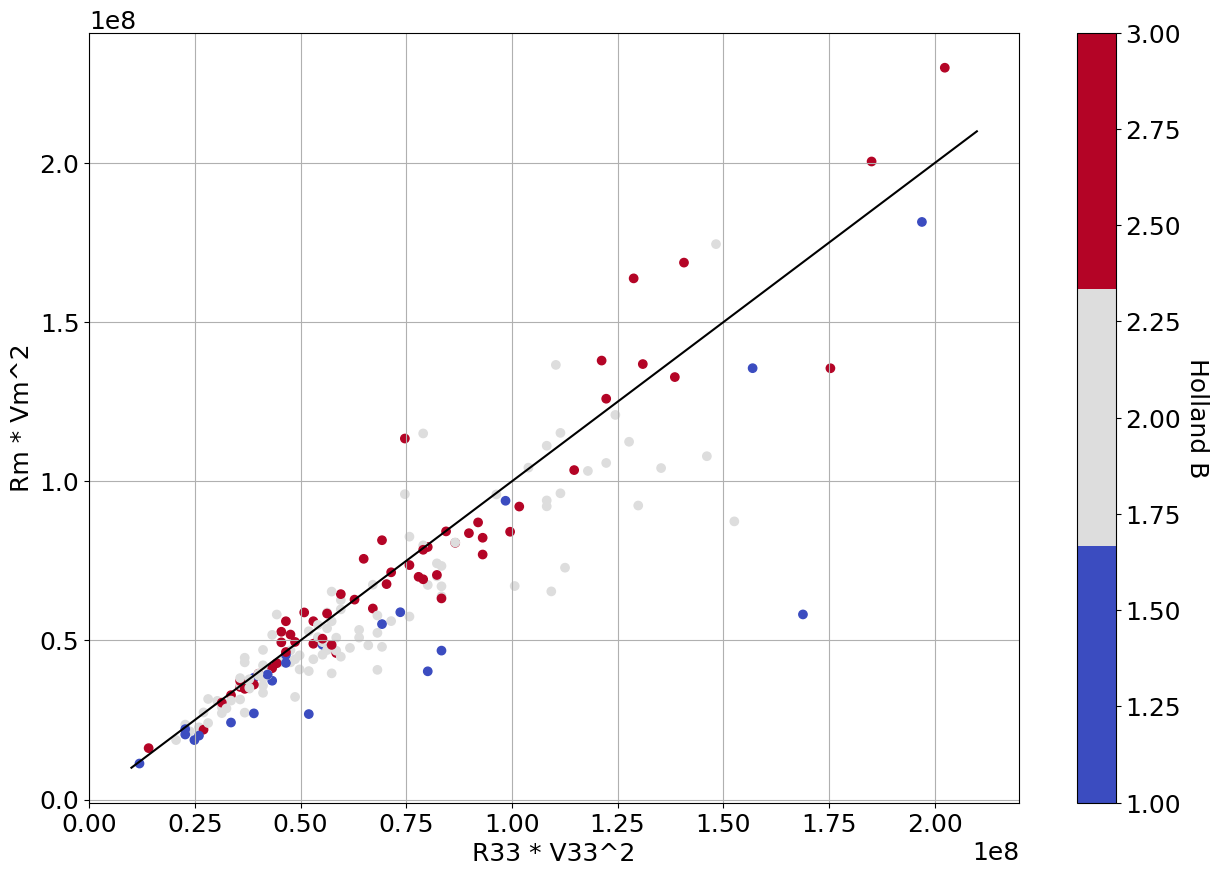

In [140]:
# plt.scatter(dsg['R17_1D'] * 1000 * 17.5 ** 2, dsg['Rmax_1D'] * 1000 * dsg['Vmax_1D'] ** 2, c=dsg.Vmax_dot_smth_IBT, vmin=-1, vmax=1, cmap=cm.get_cmap('coolwarm', 3))
plt.scatter(dsg['R33_1D'] * 1000 * 32.9 ** 2, dsg['Rmax_1D'] * 1000 * dsg['Vmax_1D'] ** 2, c=dsg.B_hol, vmin=1, vmax=3, cmap=cm.get_cmap('coolwarm', 3))
plt.grid()
plt.xlabel('R33 * V33^2');plt.ylabel('Rm * Vm^2')

cbar    = plt.colorbar()
cbar.set_label('Holland B', rotation=270)
cbar.ax.get_yaxis().labelpad=20

plt.plot([0.1e8, 2.1e8], [0.1e8, 2.1e8], c='k')

In [119]:
dsg['tau'] = 100 * 17.5 * dsg['R17_1D'] * 1000 / (dsg['Rmax_1D'] * 1000 * dsg['Vmax_1D'] ** 2) # hours
# dsg['tau'] = 100 * 17.5 * dsg['R17_1D'] * 1000 / (dsg['Rmax_1D'] * 1000 * dsg['Vmax_1D'] ** 2) # hours

In [135]:
# plt.scatter(dsg['hrs_since_lmi'], dsg['tau'], c=dsg.B_hol, vmin=1, vmax=3, cmap=cm.get_cmap('coolwarm', 3))

In [126]:
# dsg['tau2'] = (dsg['Rmax_1D'] * 1000 / dsg['Vmax_1D']) / 3600 # hours
# plt.scatter(dsg['hrs_since_lmi'], dsg['tau'] / dsg['tau2'], c=dsg.B_hol, vmin=1, vmax=3, cmap=cm.get_cmap('coolwarm', 3))